In [14]:
import os, pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

#### Import all data

In [2]:
DATA_DIR = '..\\data\\raw'
INTERIM_DIR = '..\\data\\interim'
FINAL_DIR = '..\\data\\final'

In [3]:
movies_df = pd.read_csv(os.path.join(FINAL_DIR, 'movies.csv'))
movies_df

,Unnamed: 0,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres,averageRating,...,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
0,1,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,70,"Action,Adventure,Biography",6.1,...,0,0,0,0,0,0,0,0,0,0
1,2,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,90,Drama,4.6,...,0,0,0,0,0,0,0,0,0,0
2,3,tt0000615,movie,Robbery Under Arms,Robbery Under Arms,0,1907,94,Drama,4.5,...,0,0,0,0,0,0,0,0,0,0
3,4,tt0000630,movie,Hamlet,Amleto,0,1908,94,Drama,3.8,...,0,0,0,0,0,0,0,0,0,0
4,5,tt0000675,movie,Don Quijote,Don Quijote,0,1908,94,Drama,4.9,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264914,275171,tt9916190,movie,Safeguard,Safeguard,0,2020,90,"Action,Adventure,Thriller",3.6,...,0,0,0,0,0,0,0,1,0,0
264915,275172,tt9916270,movie,Il talento del calabrone,Il talento del calabrone,0,2020,84,Thriller,5.8,...,0,0,0,0,0,0,0,1,0,0
264916,275173,tt9916362,movie,Coven,Akelarre,0,2020,92,"Drama,History",6.4,...,0,0,0,0,0,0,0,0,0,0
264917,275174,tt9916428,movie,The Secret of China,Hong xing zhao yao Zhong guo,0,2019,94,"Adventure,History,War",3.8,...,0,0,0,0,0,0,0,0,1,0


### Clustering the data using KMeans to find natural data distribution

**Description of Approach:**

1. The problem at hand is a regression problem. We are going to regress the _averageRating_ of a movie from its features.
2. In classification problems, to ensure that the trained model's accuracy is representative of its _in-the-wild_ performance, we sample the data in a **stratified** manner. That is, both the train and test datasets have the same proportion of examples from each class.
3. However, in regression, the labels are continuous. Therefore, we take a different approach - we find out the natural clustering of the data using the label that we are going to regress and some/all of the features in the data.
 - We perform KMeans clustering on the data using a range of values for K
 - We then plot a graph of _inertia_ vs K
 - We find out the **elbow** of this plot 
 - The value corresponding to the elbow is the natural number of clusters of the data.
4. The training and testing set will then have an equal proportion of samples from each cluster.

In [4]:
# List out all columns

movies_df.columns

Index(['Unnamed: 0', 'tconst', 'titleType', 'primaryTitle', 'originalTitle',
       'isAdult', 'startYear', 'runtimeMinutes', 'genres', 'averageRating',
       'numVotes', 'pi_mean_mean', 'pi_mean_std', 'pi_med_mean', 'pi_med_std',
       'pi_std_mean', 'pi_std_std', 'Action', 'Adult', 'Adventure',
       'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Family', 'Fantasy', 'Film-Noir', 'Game-Show', 'History', 'Horror',
       'Music', 'Musical', 'Mystery', 'News', 'Reality-TV', 'Romance',
       'Sci-Fi', 'Short', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western'],
      dtype='object')

In [10]:
# Take the columns that are of interest for clustering

clustering_cols = [ 'titleType', 'isAdult', 'startYear', 'runtimeMinutes', 'averageRating',\
                   'numVotes', 'pi_mean_mean', 'pi_mean_std', 'pi_med_mean', 'pi_med_std',\
                   'pi_std_mean', 'pi_std_std', 'Action', 'Adult',\
                   'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary',\
                   'Drama', 'Family', 'Fantasy', 'Film-Noir', 'Game-Show', 'History',\
                   'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Reality-TV',\
                   'Romance', 'Sci-Fi', 'Short', 'Sport', 'Talk-Show', 'Thriller', 'War','Western']

### Normalize and preprocess each column appropriately for clustering

In [11]:
clustering_df = movies_df[clustering_cols].copy()

numerical_cols = ['runtimeMinutes', 'averageRating','numVotes', \
                  'pi_mean_mean', 'pi_mean_std', 'pi_med_mean', 'pi_med_std',\
                  'pi_std_mean', 'pi_std_std']

categorical_cols = ['titleType']

ordinal_cols = ['startYear']

In [12]:
# Apply standard normalization to numerical cols and labelencoding to categorical cols

def norm_preprocess(data, 
                    numerical_cols=None, 
                    categorical_cols=None,
                    ordinal_cols=None):
    '''
    Normalize and preprocess cols according to their variabletype 
    
    params:
        - data                 (DataFrame): Data to preprocess
        - numerical_cols     (list of str): list of numerical cols
        - categorical_cols   (list of str): list of categorical_cols
        - ordinal_cols       (list of str): list of ordinal cols
        
    returns:
        - data                 (DataFrame): Preprocessed Data
    '''
    if numerical_cols:
        print("Processing numerical cols ...")
        data.loc[:, numerical_cols] = StandardScaler().fit_transform(data[numerical_cols])

    if ordinal_cols:
        print("Processing ordinal cols ...")
        data.loc[:, ordinal_cols] = OrdinalEncoder().fit_transform(data[ordinal_cols]).astype(int)
        
    if categorical_cols:
        print("Processing categorical cols ...")
        for col in tqdm(categorical_cols):

            # fit encoder, transform col, replace 
            encoder = OneHotEncoder(sparse=False)
            encoder.fit(data[[col]])
            transformed = encoder.transform(data[col].values.reshape(-1,1))
            classes = encoder.categories_

            transformed_df = pd.DataFrame(data=transformed.astype(int), columns=list(classes[0]))
            # replace column with one hot encoding
            data = pd.concat([data, transformed_df], axis=1)
            del data[col]
    
    return data

In [15]:
clustering_df = norm_preprocess(clustering_df,
                                numerical_cols=numerical_cols,
                                categorical_cols=categorical_cols,
                                ordinal_cols=ordinal_cols)

clustering_df

Processing numerical cols ...
Processing ordinal cols ...
Processing categorical cols ...


100%|██████████| 1/1 [00:00<00:00, 19.61it/s]


,isAdult,startYear,runtimeMinutes,averageRating,numVotes,pi_mean_mean,pi_mean_std,pi_med_mean,pi_med_std,pi_std_mean,...,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western,movie
0,0,9,-0.175720,-0.039029,-0.083313,-0.381980,-0.905697,-0.313254,-1.134583,-0.028281,...,0,0,0,0,0,0,0,0,0,1
1,0,10,-0.031276,-1.163983,-0.104837,-1.350426,-0.398062,-1.266415,-0.339868,-0.924039,...,0,0,0,0,0,0,0,0,0,1
2,0,10,-0.002387,-1.238980,-0.104662,-1.803966,-0.334352,-1.843160,-0.369209,1.014870,...,0,0,0,0,0,0,0,0,0,1
3,0,11,-0.002387,-1.763958,-0.104632,-1.472292,-0.529283,-1.128608,-0.718983,1.465865,...,0,0,0,0,0,0,0,0,0,1
4,0,11,-0.002387,-0.938992,-0.104779,-1.546837,0.142573,-1.559253,0.080288,-0.054926,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264914,0,123,-0.031276,-1.913952,-0.098579,-0.231269,-0.452031,0.082939,-0.134119,3.335389,...,0,0,0,0,0,0,1,0,0,1
264915,0,123,-0.074609,-0.264020,-0.067082,0.306432,-0.745221,0.289648,-0.672035,-0.459342,...,0,0,0,0,0,0,1,0,0,1
264916,0,123,-0.016831,0.185961,0.024074,0.240314,-0.886348,0.163326,-0.875658,-0.710556,...,0,0,0,0,0,0,0,0,0,1
264917,0,122,-0.002387,-1.763958,-0.104925,-0.815966,0.591816,-0.803232,0.712752,-0.014580,...,0,0,0,0,0,0,0,1,0,1


In [16]:
clustering_df.columns

Index(['isAdult', 'startYear', 'runtimeMinutes', 'averageRating', 'numVotes',
       'pi_mean_mean', 'pi_mean_std', 'pi_med_mean', 'pi_med_std',
       'pi_std_mean', 'pi_std_std', 'Action', 'Adult', 'Adventure',
       'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Family', 'Fantasy', 'Film-Noir', 'Game-Show', 'History', 'Horror',
       'Music', 'Musical', 'Mystery', 'News', 'Reality-TV', 'Romance',
       'Sci-Fi', 'Short', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western',
       'movie'],
      dtype='object')

In [17]:
# Get numpy array of features in shape : (num_samples, num_features)
cluster_features_array = clustering_df.values

print(cluster_features_array.shape)

(264919, 40)


### Get the elbow plot

In [18]:
def get_cluster_inertias(data, k_range):
    '''
    Get Kmeans inertias for k in range k_range
    
    params:
        - data                 (DataFrame): Data to cluster
        - k_range                   (list): range of k for Kmeans
    
    returns:
        -    (list of tuples (int, float)): tuples of (k, inertia)
    '''
    
    cluster_inertias = []
    
    for k in tqdm(k_range):
        
        kmeans = KMeans(n_clusters=k, n_jobs=-1)
        kmeans.fit(data)
        cluster_inertias.append(kmeans.inertia_)
    
    return (k_range, cluster_inertias)

In [19]:
k, cluster_inertias = get_cluster_inertias(cluster_features_array, list(range(2,50)))

100%|██████████| 48/48 [11:56<00:00, 14.93s/it]


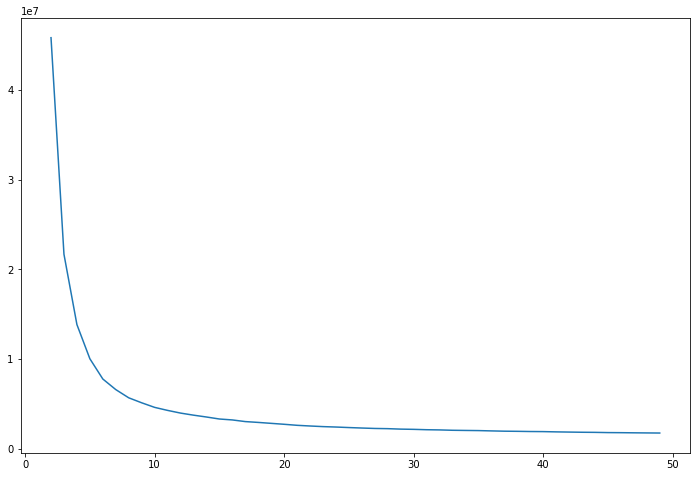

In [20]:
plt.figure(figsize=(12,8))
plt.plot(k, cluster_inertias)  

### From the plot above, we can see that the elbow is at 10. So we cluster our data using K=10

In [21]:
# Initialize Kmeans object with 10 as k
kmeans = KMeans(n_clusters=10, n_jobs=-1)

# Fit clustering object and get cluster labels for our dataset
cluster_labels = kmeans.fit_predict(cluster_features_array)

cluster_labels

array([6, 6, 6, ..., 5, 5, 5])

In [22]:
cluster_labels.shape

(264919,)

In [23]:
# set a column in our dataset to be the cluster label to sample from 
movies_df['cluster'] = list(cluster_labels)

### Preprocess the data to use in training/testing process

#### Preprocessing object to be used in training and deployment

In [24]:
class Preprocess:
    '''
    Class to store the preprocessing so that the preprocessing
    used in training can be easily applied to test data
    
    - Store the parameters of the sklearn encoders used in preprocessing
      (for eg. mean, std of StandardScaler)
    - Map estimators to column names 
    - Methods for applying the preprocessing to test data
    '''
    def __init__(self, data, 
                 numerical_cols=None,
                 categorical_cols=None, 
                 ordinal_cols=None):
        
        self.numerical_cols = numerical_cols
        self.categorical_cols = categorical_cols
        self.ordinal_cols = ordinal_cols
        
        self.standScaler = StandardScaler()
        self.ordScaler = OrdinalEncoder()
        self.oneHotEncoders = dict(zip(categorical_cols,
                                       [OneHotEncoder(sparse=False)
                                        for col in categorical_cols]))
        
        self.fit(data)
    
    def fit(self, data):
        '''
        Fit all encoders
        '''
        self.standScaler.fit(data[self.numerical_cols])
        self.ordScaler.fit(data[self.ordinal_cols])
        
        for col in self.categorical_cols:
            self.oneHotEncoders[col].fit(data[[col]])
        
        print('Fitting process completed')
        
    def transform(self, test_data):
        '''
        Transform test data in the same way as training data was transformed
        '''
        # Transform numerical data
        if self.numerical_cols:
            
            print("Transforming numerical cols ...")
            test_data.loc[:, self.numerical_cols] = self.standScaler.transform(test_data[self.numerical_cols])
        
        # Transform ordinal data
        if self.ordinal_cols:
            
            print("Transforming ordinal cols ...")
            test_data.loc[:, self.ordinal_cols] = self.ordScaler.transform(test_data[self.ordinal_cols])
        
        # Transform categorical data
        if self.categorical_cols:
            
            print("Transforming ordinal cols ...")       
            
            for col in tqdm(self.categorical_cols):
                
                # fit encoder, transform col, replace
                encoder = self.oneHotEncoders[col]
                transformed = encoder.transform(test_data[col].values.reshape(-1,1))
                classes = encoder.categories_

                transformed_df = pd.DataFrame(data=transformed.astype(int), columns=list(classes[0]))
                test_data = pd.concat([test_data, transformed_df], axis=1)
                del test_data[col]
        
        return test_data

In [25]:
preprocessor = Preprocess(movies_df,
                          numerical_cols=numerical_cols,
                          categorical_cols=categorical_cols,
                          ordinal_cols=ordinal_cols)

Fitting process completed


In [26]:
preprocessor.transform(movies_df)

Transforming numerical cols ...
Transforming ordinal cols ...
Transforming ordinal cols ...


100%|██████████| 1/1 [00:00<00:00, 16.95it/s]


,Unnamed: 0,tconst,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres,averageRating,numVotes,...,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western,cluster,movie
0,1,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,0,9.0,-0.175720,"Action,Adventure,Biography",-0.039029,-0.083313,...,0,0,0,0,0,0,0,0,6,1
1,2,tt0000591,The Prodigal Son,L'enfant prodigue,0,10.0,-0.031276,Drama,-1.163983,-0.104837,...,0,0,0,0,0,0,0,0,6,1
2,3,tt0000615,Robbery Under Arms,Robbery Under Arms,0,10.0,-0.002387,Drama,-1.238980,-0.104662,...,0,0,0,0,0,0,0,0,6,1
3,4,tt0000630,Hamlet,Amleto,0,11.0,-0.002387,Drama,-1.763958,-0.104632,...,0,0,0,0,0,0,0,0,6,1
4,5,tt0000675,Don Quijote,Don Quijote,0,11.0,-0.002387,Drama,-0.938992,-0.104779,...,0,0,0,0,0,0,0,0,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264914,275171,tt9916190,Safeguard,Safeguard,0,123.0,-0.031276,"Action,Adventure,Thriller",-1.913952,-0.098579,...,0,0,0,0,0,1,0,0,5,1
264915,275172,tt9916270,Il talento del calabrone,Il talento del calabrone,0,123.0,-0.074609,Thriller,-0.264020,-0.067082,...,0,0,0,0,0,1,0,0,5,1
264916,275173,tt9916362,Coven,Akelarre,0,123.0,-0.016831,"Drama,History",0.185961,0.024074,...,0,0,0,0,0,0,0,0,5,1
264917,275174,tt9916428,The Secret of China,Hong xing zhao yao Zhong guo,0,122.0,-0.002387,"Adventure,History,War",-1.763958,-0.104925,...,0,0,0,0,0,0,1,0,5,1


### Save the preprocessor object in a pickle file for production use

In [27]:
with open(os.path.join(FINAL_DIR, 'preprocessor.pkl'), 'wb') as f:
    pickle.dump(preprocessor, f)

### Train Test split

**Methodology:**

1. Decide the percentage of data to be used for training.
2. Randomly sample that percentage of data from each cluster to create the training set
   and the rest in test set

In [28]:
movies_df.columns

Index(['Unnamed: 0', 'tconst', 'titleType', 'primaryTitle', 'originalTitle',
       'isAdult', 'startYear', 'runtimeMinutes', 'genres', 'averageRating',
       'numVotes', 'pi_mean_mean', 'pi_mean_std', 'pi_med_mean', 'pi_med_std',
       'pi_std_mean', 'pi_std_std', 'Action', 'Adult', 'Adventure',
       'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Family', 'Fantasy', 'Film-Noir', 'Game-Show', 'History', 'Horror',
       'Music', 'Musical', 'Mystery', 'News', 'Reality-TV', 'Romance',
       'Sci-Fi', 'Short', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western',
       'cluster'],
      dtype='object')

In [30]:
TRAIN_RATIO = 0.7

trainSet_dfs = []
test_set_dfs = []

cols_to_consider = ['isAdult', 'startYear', 'runtimeMinutes', 'averageRating',\
                    'numVotes', 'pi_mean_mean', 'pi_mean_std', 'pi_med_mean', \
                    'pi_med_std','pi_std_mean', 'pi_std_std', \
                    'Action', 'Adult','Adventure', 'Animation', 'Biography', \
                    'Comedy', 'Crime', 'Documentary','Drama', 'Family', 'Fantasy',\
                    'Film-Noir', 'Game-Show', 'History', 'Horror', 'Music', 'Musical',\
                    'Mystery', 'News', 'Reality-TV','Romance', 'Sci-Fi', 'Short',\
                    'Sport', 'Talk-Show', 'Thriller', 'War','Western']

# Since we have 10 clusters
for cluster_label in tqdm(range(10)):
    
    cluster_rows = movies_df[movies_df['cluster']==cluster_label]
    
    # Randomly shuffle rows in the slice
    cluster_rows = cluster_rows.sample(frac=1)
    num_rows_training = int(TRAIN_RATIO*len(cluster_rows))
    
    trainSet_dfs.append(cluster_rows[:num_rows_training])
    test_set_dfs.append(cluster_rows[num_rows_training:])

train_set = pd.concat(trainSet_dfs, axis=0)[cols_to_consider]
test_set = pd.concat(test_set_dfs, axis=0)[cols_to_consider]

print("Length of train set : {}".format(len(train_set)))
print("Length of test set: {}".format(len(test_set)))

100%|██████████| 10/10 [00:00<00:00, 68.97it/s]


Length of train set : 185439
Length of test set: 79480


In [31]:
train_set.head()

,isAdult,startYear,runtimeMinutes,averageRating,numVotes,pi_mean_mean,pi_mean_std,pi_med_mean,pi_med_std,pi_std_mean,...,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
152218,0,111.0,-0.356276,0.260958,-0.097643,0.507567,-0.553463,0.569362,-0.405845,-0.215987,...,0,0,0,0,0,0,0,0,0,0
192898,0,115.0,0.142058,-0.863995,0.208200,-0.205016,0.182538,-0.198416,0.323312,-0.227171,...,0,0,0,0,0,0,0,0,0,0
222264,0,113.0,-0.002387,-0.339017,-0.104954,0.559239,0.223280,0.611196,0.045127,-0.610878,...,0,0,0,0,0,0,0,0,0,0
219996,0,117.0,-0.284054,1.385912,-0.105130,0.089116,-1.352289,-0.066351,-1.246429,-0.414034,...,0,0,0,0,0,0,0,0,0,0
230703,0,115.0,-0.349054,0.260958,-0.104866,0.243474,-0.694911,0.278164,-0.882432,-0.700646,...,0,0,0,0,0,0,0,0,0,0


In [32]:
train_set.to_csv(os.path.join(FINAL_DIR, 'train_set.csv'), index=False)
test_set.to_csv(os.path.join(FINAL_DIR, 'test_set.csv'), index=False)